# Statistics on the output data. 

### Loading data from the sqlite database to the dataframes

In [189]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import lizard
import subprocess as sub
from pylibsrcml import srcml
import os
import re 
import xml.etree.ElementTree as et 
import warnings
from sqlite3 import connect
from argparse import ArgumentParser
from configparser import ConfigParser
import yaml
from pathlib import Path
import random
from tabulate import tabulate

warnings.filterwarnings("ignore")


# database = '../data/IoT.db'
# database = '../data/TinyVul.db'
database = "/Users/guru/research/TinyVul-v2.db"
conn= connect(database)

random.seed(0)

dfp = pd.read_sql_query("SELECT * FROM project", con=conn)
dfs = pd.read_sql_query("SELECT * FROM statement", con=conn)
dff = pd.read_sql_query("SELECT * FROM function", con=conn)

if not os.path.exists("figure"):
    os.mkdir("figure")
dfs.columns

Index(['file', 'line', 'column', 'defaultlevel', 'level', 'category', 'name',
       'msg', 'note', 'cwe', 'context', 'helpuri', 'severity', 'tool', 'type',
       'project'],
      dtype='object')

### Plotting subburset plot from the frequency of category, name and cwe types. 

In [190]:
dfplt = dfs[['category', 'name', 'cwe']].groupby(['category', 'name', 'cwe'], group_keys=False).size().reset_index(name='count')
fig = px.sunburst(dfplt, 
    path=['category', 'name', 'cwe'], 
    values='count', 
    color_continuous_scale='Blues',
    color='count',
)
# fig.write_image("figure/vul_statistics.pdf")
# fig.update_traces(hovertemplate='%{label}<br>%{customdata}')
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
fig.show()
# save the figure manually, the below code takes ages
# fig.write_image("../figure/vul_statistics.pdf")

In [218]:
dfplt['cate']

,category,name,cwe,count
0,Static Global Buffer,-,CWE-unknown,3
1,buffer,char,CWE-119!/CWE-120,34
2,buffer,getchar,"CWE-120, CWE-20",2
3,buffer,memcpy,CWE-120,25
4,buffer,sprintf,CWE-120,40
5,buffer,strcpy,CWE-120,3
6,buffer,strlen,CWE-126,9
7,fixed size global buffer,-,CWE-unknown,31
8,fixed size local buffer,-,CWE-unknown,2
9,format,snprintf,CWE-134,2


In [191]:
dfplt.sort_values(by=['count'], ascending=False).head(10)

,category,name,cwe,count
17,snprintf,-,CWE-unknown,56
4,buffer,sprintf,CWE-120,40
1,buffer,char,CWE-119!/CWE-120,34
7,fixed size global buffer,-,CWE-unknown,31
18,sprintf,-,CWE-unknown,29
3,buffer,memcpy,CWE-120,25
13,memcpy,-,CWE-unknown,25
10,format,sprintf,CWE-134,9
19,strlen,-,CWE-unknown,9
6,buffer,strlen,CWE-126,9


# Top 10 vulnerabilities

In [192]:
df_top10 = dfplt.sort_values(by=['count'], ascending=False).head(10).reset_index(drop=True)
print(tabulate(df_top10, headers='keys', tablefmt='psql'))
df_top10.to_latex("../result/top10.tex", index=False, caption="Top 10 CWEs in IoT code")

+----+--------------------------+---------+------------------+---------+
|    | category                 | name    | cwe              |   count |
|----+--------------------------+---------+------------------+---------|
|  0 | snprintf                 | -       | CWE-unknown      |      56 |
|  1 | buffer                   | sprintf | CWE-120          |      40 |
|  2 | buffer                   | char    | CWE-119!/CWE-120 |      34 |
|  3 | fixed size global buffer | -       | CWE-unknown      |      31 |
|  4 | sprintf                  | -       | CWE-unknown      |      29 |
|  5 | buffer                   | memcpy  | CWE-120          |      25 |
|  6 | memcpy                   | -       | CWE-unknown      |      25 |
|  7 | format                   | sprintf | CWE-134          |       9 |
|  8 | strlen                   | -       | CWE-unknown      |       9 |
|  9 | buffer                   | strlen  | CWE-126          |       9 |
+----+--------------------------+---------+--------

<AxesSubplot: >

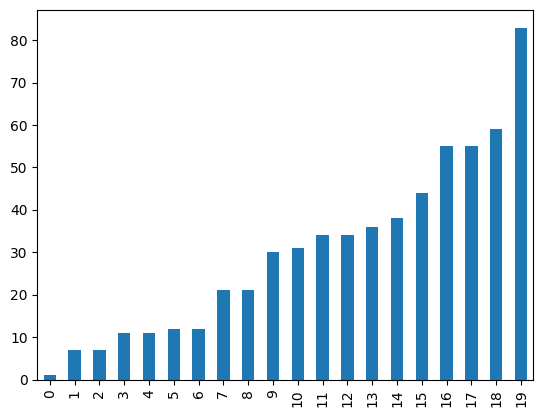

In [193]:
# dfs.context.head(200).str.len().plot(kind='bar')
pd.Series(sorted(list(dfs.context.head(20).str.len()))).plot(kind='bar')

In [194]:
dfs.context

0                      vfprintf (cb_storage_file, fmt, ap);
1                                                         -
2                                              va_end (ap);
3                                               va_list ap;
4                                              va_end (ap);
                                ...                        
117999                       if (unlikely (ipchr == EOF)) {
118000    /* always flush to ensure buffered output is s...
118001                                    temp.size = size;
118002                            p[size++] = (char) ipchr;
118003                            cob_accept (cob_field *f)
Name: context, Length: 118004, dtype: object

<AxesSubplot: ylabel='Frequency'>

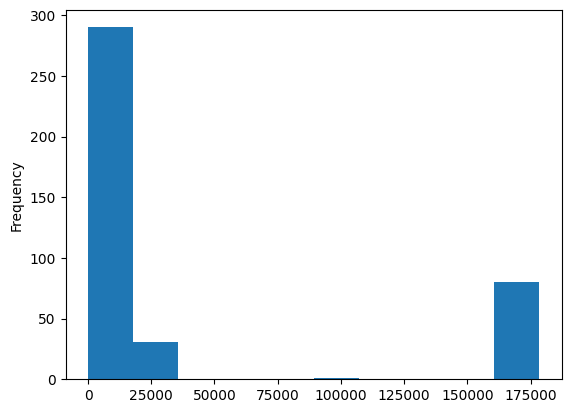

In [195]:
pd.Series([len(x) for x in dff.code if len(x)>10]).plot.hist(xlabel='#chars', ylabel='#statements')

In [196]:
def filter_unusual_statements(statements, min_len, max_len, df):
    """" 
    # https://peps.python.org/pep-0007/
    # https://www.python.org/dev/peps/pep-0007/ 

    """
    filtered_statements = []
    for statement in statements:
        if len(statement) >= min_len and len(statement) <= max_len:
            filtered_statements.append(statement)
   
    # take size of the vul statements as basis
    df = pd.Series(statements)   
    df = df.str.len()
    
    stat_sizes =  list(df[df.between(max_len, min_len)].reset_index(drop=True))
    
    sample_size = 5 if len(stat_sizes)>5 else len(stat_sizes)-1
    stat_sizes = random.sample(set(stat_sizes), sample_size)
    return stat_sizes


# standard variables:
max_len = 79  #TODO: double check pep standards

# TODO: check min_len as well, otherwise the below code unnessesarily checks one extra condition 
# because there is no any statement/fun with len below that. 
# for min_len (eg, 7 characters)
min_len = dfs.context.str.len().sort_values(ascending=False).reset_index(drop=True).min()


lines = dff.code[0].splitlines()
stat_sizes = filter_unusual_statements(lines, max_len, min_len, dfs)
stat_sizes

[13, 23, 32, 2, 38]

In [197]:
# df_dnn = pd.read_csv('../data/iDetect_refine/DNN_Binary.csv')
# df_conti = pd.read_csv('../data/contiki-master_Binary.csv')
# df_rasp = pd.read_csv('../data/raspberry_metrics.csv')
# df_rasp_flaw = pd.read_csv('../data/raspberry_flaw.csv')

# print('Shape of DNN data: ', df_dnn.shape)
# print('Shape of contiki: ', df_conti.shape)
# print('Shape of raspberry: ', df_rasp.shape)
# print('Shape of raspberry flaws: ', df_rasp_flaw.shape)

# dfcon = dfcon.rename(columns={'context': 'code'})
# dfcon.to_csv('../data/contiki-master_Binary.csv', index=False)

# Convert hyperparameters list to latex table format

In [198]:
def hyperpara2latex(yaml_file):
    """
    load the yaml file and return a dictionary
    """
    config = {}
    cols = ['hyperparameter', 'value']
    
    ext = Path(yaml_file).suffix.replace('.', '') 
    
    with open(yaml_file, "r") as stream:
        try:
            config = yaml.safe_load(stream)
            print(type(config))
            df = pd.DataFrame([config['dnn']]).T.reset_index()
            print(df.to_latex(index=False, 
                    header=cols, 
                    #   column_format='|l|l|', 
                    label='Hyperparameter Settings', 
                    caption='Hyperparameter Settings'))
        except yaml.YAMLError as exc:
            print(exc)

config = hyperpara2latex('../config.yaml')

<class 'dict'>
\begin{table}
\centering
\caption{Hyperparameter Settings}
\label{Hyperparameter Settings}
\begin{tabular}{ll}
\toprule
hyperparameter &                           value \\
\midrule
        epochs &                              50 \\
  debug\_epochs &                               3 \\
         batch &                             128 \\
  input\_length &                             150 \\
     input\_dim &                             150 \\
    output\_dim &                              32 \\
            lr &                            1e-4 \\
      patience &                             100 \\
     optimizer &                            adam \\
        l2\_reg &                            1e-4 \\
       dropout &                             0.0 \\
 recur\_dropout &                             0.0 \\
        beta\_1 &                             0.9 \\
        beta\_2 &                           0.999 \\
       epsilon &                           1e-08 \\
         decay &

## Frequency of the vulnerabilities and benign samples at 
    - statement-level 
    - function-level

In [199]:
# for project-wise distribution
projects = list(dfs.project.unique())

for project in projects:
    print(project)
    df = dfs[dfs.project == project]
    print(df.shape)
    print(df.cwe.value_counts())
    print(df.category.value_counts())
    print('----------------------')

/Users/guru/research/projects/gnucobol
(118004, 16)
Benign              117717
CWE-unknown            159
CWE-120                 68
CWE-119!/CWE-120        34
CWE-134                 12
CWE-126                  9
CWE-362                  2
CWE-120, CWE-20          2
CWE-78                   1
Name: cwe, dtype: int64
buffer                      113
snprintf                     56
fixed size global buffer     31
sprintf                      29
memcpy                       25
format                       12
strlen                        9
Static Global Buffer          3
misc                          2
getchar                       2
fixed size local buffer       2
vfprintf                      1
shell                         1
popen                         1
Name: category, dtype: int64
----------------------


## Create a latex table from the statistics of projects

In [200]:
def save_latex(df, file):
    """
    save the dataframe as latex table
    """
    styler = df.style
    # styler.applymap_index(lambda v: "font-weight: bold;", axis="index")
    styler.applymap_index(lambda v: "font-weight: bold;", axis="columns")
    res = styler.to_latex(convert_css=True, column_format='|l|l|r|')

    with open(file, 'w') as f:
        f.write(res)
    return res

# make class binary type benign/vulnerable
dfs_binary = dfs.copy()
dfs_binary.loc[dfs_binary.cwe!="Benign", 'cwe'] = "Vulnerable"
dfs_binary['project'] = dfs_binary.project.str.split('/').str[-1]

prj_stat = dfs_binary.groupby(['project', 'cwe']).size().reset_index(name='count')
prj_s = prj_stat.groupby(['project', 'cwe']).sum()

res = tabulate(save_latex(prj_s, '../result/project_stat.tex'))
prj_s

count
project  cwe               
gnucobol Benign      117717
         Vulnerable     287

In [201]:
prj_sflat = prj_s.reset_index()
prj_sflat = prj_sflat.pivot(index='project', columns='cwe', values='count')
prj_sflat.reset_index().to_latex('../result/project_stat_flat.tex', index=False)

In [202]:
# make class binary type benign/vulnerable
dff_binary = dff.copy()
dff_binary.loc[dff_binary.cwe!="Benign", 'cwe'] = "Vulnerable"

prj_ff = dff_binary.groupby(['project', 'cwe']).size().reset_index(name='count')
prj_f = prj_ff.groupby(['cwe']).sum().sort_values(by='count', ascending=False).reset_index()
prj_f = prj_f[prj_f.cwe != 'Benign'].head(10)
print(prj_f.to_latex(index=False, caption='Top 10 CWEs', label='Top 10 CWEs'))

\begin{table}
\centering
\caption{Top 10 CWEs}
\label{Top 10 CWEs}
\begin{tabular}{lr}
\toprule
       cwe &  count \\
\midrule
Vulnerable &    217 \\
\bottomrule
\end{tabular}
\end{table}



In [203]:
prj_s = dfs.groupby(['project', 'cwe']).size().reset_index(name='count')
prj_s = prj_s.groupby(['cwe']).sum()
prj_s

,count
cwe,
Benign,117717
CWE-119!/CWE-120,34
CWE-120,68
"CWE-120, CWE-20",2
CWE-126,9
CWE-134,12
CWE-362,2
CWE-78,1
CWE-unknown,159


# Show the description of the function-level data

In [204]:
df_describe = dff_binary.drop(
    labels=['top_nesting_level', 'fan_in', 'fan_out', 'general_fan_out', 'content', 'long_name', 'fun_name', 'full_parameters', 'code'],
    axis=1, 
    errors='ignore').describe().T

df_freq = df_describe.reset_index().rename(columns={'index': 'features'})
df_freq = df_freq.drop(labels=['count'], axis=1)
# The freq is the most common value’s frequency. The top is the most common value.

print(df_freq[~df_freq.features.isin(['file'])].to_latex(
    index=False, 
    column_format='rrrrr', 
    label='Function Statistics', 
    caption='Function Statistics')
    )

\begin{table}
\centering
\caption{Function Statistics}
\label{Function Statistics}
\begin{tabular}{rrrrr}
\toprule
features & unique &                                    top & freq \\
\midrule
 context &    112 &                                        &  185 \\
     cwe &      2 &                             Vulnerable &  217 \\
 project &      1 & /Users/guru/research/projects/gnucobol &  402 \\
\bottomrule
\end{tabular}
\end{table}



In [205]:
dfs.cwe.value_counts()

Benign              117717
CWE-unknown            159
CWE-120                 68
CWE-119!/CWE-120        34
CWE-134                 12
CWE-126                  9
CWE-362                  2
CWE-120, CWE-20          2
CWE-78                   1
Name: cwe, dtype: int64

In [206]:
dff.cwe.value_counts()

CWE-unknown    217
Benign         185
Name: cwe, dtype: int64

In [207]:
print(f'Size of statements: {len(dfs.context)}')
print(f'Size of unique statements: {dfs.context.nunique()}')

print(f'\nSize of functions: {len(dff.code)}')
print(f'Size of unique functions: {dff.code.nunique()}')

Size of statements: 118004
Size of unique statements: 2362

Size of functions: 402
Size of unique functions: 185


In [208]:
dff[dff.cwe=='Benign'].drop_duplicates().reset_index(drop=True)

,file,code,context,cwe,project
0,/Users/guru/research/projects/gnucobol/cobc/co...,"static void\noutput_storage (const char *fmt, ...",,Benign,/Users/guru/research/projects/gnucobol
1,/Users/guru/research/projects/gnucobol/cobc/co...,void\ncob_gen_optim (const enum cb_optim val)\...,,Benign,/Users/guru/research/projects/gnucobol
2,/Users/guru/research/projects/gnucobol/cobc/tr...,"static int\nwas_prev_warn (int linen, int tf)\...",,Benign,/Users/guru/research/projects/gnucobol
3,/Users/guru/research/projects/gnucobol/cobc/tr...,"static void\ncopy_file_line (cb_tree e, cb_tre...",,Benign,/Users/guru/research/projects/gnucobol
4,/Users/guru/research/projects/gnucobol/cobc/tr...,static size_t\nword_hash (const unsigned char ...,,Benign,/Users/guru/research/projects/gnucobol
...,...,...,...,...,...
180,/Users/guru/research/projects/gnucobol/libcob/...,static void\ndump_field_internal (const int le...,,Benign,/Users/guru/research/projects/gnucobol
181,/Users/guru/research/projects/gnucobol/libcob/...,"void\ncob_dump_field (const int level, const c...",,Benign,/Users/guru/research/projects/gnucobol
182,/Users/guru/research/projects/gnucobol/libcob/...,"void\ncob_dump_field_ext (const int level, con...",,Benign,/Users/guru/research/projects/gnucobol
183,/Users/guru/research/projects/gnucobol/libcob/...,void\ncob_accept (cob_field *f)\n{\n\tunsigned...,,Benign,/Users/guru/research/projects/gnucobol


In [209]:
print(len(dff[dff.cwe!='Benign'].reset_index(drop=True)))
dff[dff.cwe!='Benign'].drop_duplicates().reset_index(drop=True).head(5)

217


,file,code,context,cwe,project
0,/Users/guru/research/projects/gnucobol/cobc/co...,"static void\noutput_storage (const char *fmt, ...","vfprintf (cb_storage_file, fmt, ap);",CWE-unknown,/Users/guru/research/projects/gnucobol
1,/Users/guru/research/projects/gnucobol/cobc/tr...,static void\nlookup_word (struct cb_reference ...,"size_element = sprintf (s, ""%s%s"", buff, CB_CH...",CWE-unknown,/Users/guru/research/projects/gnucobol
2,/Users/guru/research/projects/gnucobol/cobc/tr...,static void\nlookup_word (struct cb_reference ...,"size_refmod = sprintf (s, "" (%s:"", buff);",CWE-unknown,/Users/guru/research/projects/gnucobol
3,/Users/guru/research/projects/gnucobol/cobc/tr...,static void\nlookup_word (struct cb_reference ...,"size_refmod += sprintf (s + size_refmod, ""%s)""...",CWE-unknown,/Users/guru/research/projects/gnucobol
4,/Users/guru/research/projects/gnucobol/cobc/tr...,static void\nlookup_word (struct cb_reference ...,"size_refmod = sprintf (s, "" (%s:)"", buff);",CWE-unknown,/Users/guru/research/projects/gnucobol


In [210]:
# dff_new = dff.drop_duplicates().reset_index(drop=True)
dff.loc[dff.astype(str).drop_duplicates().index].reset_index(drop=True)

,file,code,context,cwe,project
0,/Users/guru/research/projects/gnucobol/cobc/co...,"static void\noutput_storage (const char *fmt, ...","vfprintf (cb_storage_file, fmt, ap);",CWE-unknown,/Users/guru/research/projects/gnucobol
1,/Users/guru/research/projects/gnucobol/cobc/co...,"static void\noutput_storage (const char *fmt, ...",,Benign,/Users/guru/research/projects/gnucobol
2,/Users/guru/research/projects/gnucobol/cobc/co...,void\ncob_gen_optim (const enum cb_optim val)\...,,Benign,/Users/guru/research/projects/gnucobol
3,/Users/guru/research/projects/gnucobol/cobc/tr...,"static int\nwas_prev_warn (int linen, int tf)\...",,Benign,/Users/guru/research/projects/gnucobol
4,/Users/guru/research/projects/gnucobol/cobc/tr...,"static void\ncopy_file_line (cb_tree e, cb_tre...",,Benign,/Users/guru/research/projects/gnucobol
...,...,...,...,...,...
397,/Users/guru/research/projects/gnucobol/libcob/...,"void\ncob_dump_field_ext (const int level, con...",,Benign,/Users/guru/research/projects/gnucobol
398,/Users/guru/research/projects/gnucobol/libcob/...,void\ncob_accept (cob_field *f)\n{\n\tunsigned...,,Benign,/Users/guru/research/projects/gnucobol
399,/Users/guru/research/projects/gnucobol/libcob/...,void\ncob_accept (cob_field *f)\n{\n\tunsigned...,"memcpy (COB_MODULE_PTR->crt_status->data, ""0\0...",CWE-unknown,/Users/guru/research/projects/gnucobol
400,/Users/guru/research/projects/gnucobol/libcob/...,void\ncob_accept (cob_field *f)\n{\n\tunsigned...,ipchr = getchar ();,CWE-unknown,/Users/guru/research/projects/gnucobol


In [211]:
def filter_benign(code_dup, cwe):
    """ masking to filter duplicates and benign 
    keeping vulnerable samples as it is.
    """
    if code_dup == True and cwe == 'Benign':
        return True
    else:
        return False


def filter_dulicates_and_ambiquius(df):
    """ apply filtering to remove duplicates and ambiquious samples
    """
    print('='*40)
    print('Removing duplicates and ambiquious samples...')
    print('-'*40)
    df = df.sort_values(by=['code','cwe'], ascending=False)
    original_size = len(df)
    print(f'Original data size before filtering: {len(df)}')

    ## step1: remove duplicates checking ['code', 'cwe']
    df = df.drop_duplicates(subset=['code', 'cwe']).reset_index(drop=True)
    step1_size = len(df)
    print(f"Step1-filtering on [code and cwe]: {len(df)} [filtered {original_size-step1_size}]")

    ## step2: remove duplicates checking ['code']
    df['code_dup'] = df['code'].duplicated()
    # df = df[~df['code_dup']] # this removes vul samples as well
    df['filter_mask'] = df.apply(lambda row: filter_benign(row.code_dup, row.cwe), axis=1)
    df = df[~df['filter_mask']].reset_index(drop=True)
    df = df.drop(labels=['code_dup', 'filter_mask'], axis=1)
    step2_size = len(df)
    print(f"Step2-filtering on [code] with vuls: {len(df)} [filtered {step1_size-step2_size}]")
    print('='*40)
    return df

df = filter_dulicates_and_ambiquius(dff)

Removing duplicates and ambiquious samples...
----------------------------------------
Original data size before filtering: 402
Step1-filtering on [code and cwe]: 222 [filtered 180]
Step2-filtering on [code] with vuls: 185 [filtered 37]


In [212]:
df.cwe.value_counts()

Benign         148
CWE-unknown     37
Name: cwe, dtype: int64

In [213]:
dff.cwe.value_counts()

CWE-unknown    217
Benign         185
Name: cwe, dtype: int64

In [214]:
dff_sort.drop(dff_sort[dff_sort.filter_mask].index).reset_index(drop=True)

,file,code,context,cwe,project,code_dup,filter_mask
0,data/projects/contiki-2.4/apps/shell/shell-htt...,void\nwebserver_log_file(uip_ipaddr_t *request...,char buf[48];,CWE-unknown,data/projects/contiki-2.4/apps/shell/,False,False
1,data/projects/contiki-2.4/apps/shell/shell-htt...,void\nwebserver_log(char *msg)\n{\n shell_out...,,Benign,data/projects/contiki-2.4/apps/shell/,False,False
2,data/projects/contiki-2.4/apps/shell/shell-wget.c,void\nwebclient_timedout(void)\n{\n shell_out...,,Benign,data/projects/contiki-2.4/apps/shell/,False,False
3,data/projects/contiki-2.4/apps/shell/shell-wget.c,"void\nwebclient_datahandler(char *data, u16_t ...",,Benign,data/projects/contiki-2.4/apps/shell/,False,False
4,data/projects/contiki-2.4/apps/shell/shell-wget.c,void\nwebclient_connected(void)\n{\n shell_ou...,,Benign,data/projects/contiki-2.4/apps/shell/,False,False
...,...,...,...,...,...,...,...
141,data/projects/contiki-2.4/apps/shell/shell.c,"int\nshell_start_command(char *commandline, in...",,Benign,data/projects/contiki-2.4/apps/shell/,False,False
142,/Users/guru/research/projects/gnucobol-3.2/lib...,__inline\n#else\n#ifdef __cplusplus\ninline\n#...,return translation;,CWE-unknown,/Users/guru/research/projects/gnucobol-3.2/lib/,False,False
143,/Users/guru/research/projects/gnucobol-3.2/lib...,__inline\n#else\n#ifdef __cplusplus\ninline\n#...,return translation;,CWE-unknown,/Users/guru/research/projects/gnucobol-3.2/lib/,False,False
144,/Users/guru/research/projects/gnucobol-3.2/lib...,__inline\n#else\n#ifdef __cplusplus\ninline\n#...,char msg_ctxt_id[msgctxt_len + msgid_len];,CWE-unknown,/Users/guru/research/projects/gnucobol-3.2/lib/,False,False


In [215]:
dff_sort.sort_values(by=['code', 'cwe']).cwe.value_counts()

Benign         144
CWE-unknown     19
Name: cwe, dtype: int64

In [216]:
dff_new = dff_sort.copy()
dff_new = dff_new.sort_values(by=['code', 'cwe'], ascending=True)
# this code remove the duplicates and keep the last, ignores 'Benign' samples
df_dup = dff_new[dff_new.duplicated(['code'], keep='first')].reset_index(drop=True)
df_dup
# dff_new

,file,code,context,cwe,project,code_dup,filter_mask
0,/Users/guru/research/projects/gnucobol-3.2/lib...,__inline\n#else\n#ifdef __cplusplus\ninline\n#...,return translation;,CWE-unknown,/Users/guru/research/projects/gnucobol-3.2/lib/,False,False
1,/Users/guru/research/projects/gnucobol-3.2/lib...,__inline\n#else\n#ifdef __cplusplus\ninline\n#...,return translation;,CWE-unknown,/Users/guru/research/projects/gnucobol-3.2/lib/,False,False
2,data/projects/contiki-2.4/apps/shell/shell.c,static struct shell_command *\nstart_command(c...,command_len = (int)strlen(commandline);,CWE-unknown,data/projects/contiki-2.4/apps/shell/,False,False
3,data/projects/contiki-2.4/apps/shell/shell-net...,"static void\nmemcpy_misaligned(void *dest, con...","memcpy(dest, source, len);",CWE-unknown,data/projects/contiki-2.4/apps/shell/,False,False
4,data/projects/contiki-2.4/apps/shell/shell-wget.c,static void\nopen_url(char *url)\n{\n unsigne...,static char host[32];,CWE-unknown,data/projects/contiki-2.4/apps/shell/,False,False
5,data/projects/contiki-2.4/apps/shell/shell-pow...,static void\nprintpower(struct power_msg *msg)...,char buf[100];,CWE-unknown,data/projects/contiki-2.4/apps/shell/,False,False
6,data/projects/contiki-2.4/apps/shell/shell-pow...,static void\nprintpowergraph(struct power_msg ...,char buf[MAX_POWERGRAPH];,CWE-unknown,data/projects/contiki-2.4/apps/shell/,False,False
7,data/projects/contiki-2.4/apps/shell/shell-rime.c,static void\nrecv_collect(const rimeaddr_t *or...,char buf[40];,CWE-unknown,data/projects/contiki-2.4/apps/shell/,False,False
8,data/projects/contiki-2.4/apps/shell/shell-rim...,"static void\nrecv_mesh(struct mesh_conn *c, co...",char buf[64];,CWE-unknown,data/projects/contiki-2.4/apps/shell/,False,False
9,data/projects/contiki-2.4/apps/shell/shell-rim...,"static void\nrecv_uc(struct unicast_conn *c, c...","memcpy(output_blob.data, msg->data, packetbuf_...",CWE-unknown,data/projects/contiki-2.4/apps/shell/,False,False


In [217]:
# table-wise columns to check duplicates

code_col = 'code' if 'code' in df.columns else 'context'
code_col

'code'